# Numerical integration

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

## integrating a function

The area under the curve of the function.

Consider the function $ \sin(t)$ in the interval $t \in [0, \frac{\pi}{2}]$. Analytically, we know the area under the curve is the integral

$$ \int_0^{\pi / 2} \sin(t) dt = - (\cos(\pi/2) - \cos(0)) = 1$$

We will use this result to verify the correctness of numerical integration using `integrate.quad()`.

Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html

Text(0, 0.5, 'f(t)')

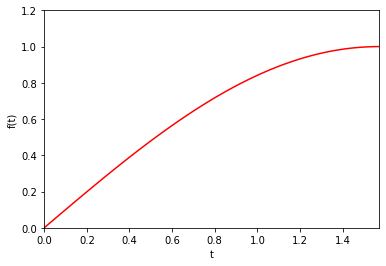

In [2]:
def func(t):
    return np.sin(t)

t = np.linspace(0, np.pi/2, 101)
plt.plot(t, func(t), 'r-')
plt.xlim([0, np.pi/2])
plt.ylim([0, 1.2])
plt.xlabel('t')
plt.ylabel('f(t)')

In [3]:
res = integrate.quad(func, 0, np.pi/2, full_output=1)

In [4]:
# y is the result of the integral. err is error.
y, err = res[0], res[1]
y, err

(0.9999999999999999, 1.1102230246251564e-14)

Other results

In [5]:
#res[2]

(0, 6.911503837897546)

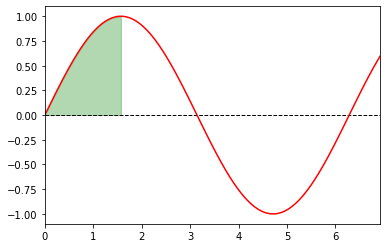

In [6]:
# visualize the area of integration (shaded in green)

t1 = np.linspace(0, 2.5*np.pi, 401)
t2 = np.linspace(0, np.pi/2, 101)
fig, ax = plt.subplots(1,1)
ax.fill_between(t2, 0, func(t2), color='green', alpha=0.3)
ax.plot(t1, func(t1), 'r-')
ax.hlines(0,0,2.5*np.pi, linewidth=1, linestyle='--')
plt.xlim([0, 2.2*np.pi])

## Integrating differential equations

A differential equation describes the rate of change of some dynamics, such as the spread of a disease, the growth of population, etc.

### Example 1

Consider the differential equation

$$ \frac{dy}{dt} = -2 y $$

with the initial condition $y(t=0) = 1$ in the interval $t \in [0, 4]$.

Analytically, we know the exact solution is

$$ y(t) = \exp(-2t) $$

We will use this analytical results to verify our numerical computation.

In [7]:
def y_ana(t):
    return np.exp(-2*t)

def yprime(y, t):
    return -2*y

t = np.linspace(0, 4, 101)
y = integrate.odeint(yprime, y0=1, t=t)

(0, 4.1)

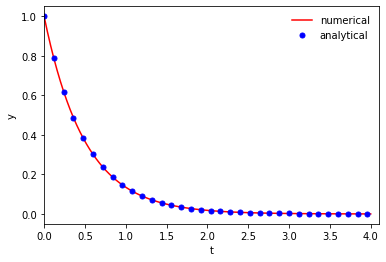

In [8]:
# plot the solution
plt.plot(t, y, 'r-', label='numerical')
plt.plot(t[::3], y_ana(t[::3]), 'bo', label='analytical', markersize=5)
plt.legend(frameon=False)
plt.xlabel('t')
plt.ylabel('y')
plt.xlim([0,4.1])

### Example 2

Consider the spring-mass oscillator described in https://en.wikipedia.org/wiki/Harmonic_oscillator#Damped_harmonic_oscillator

The differential equation is 

$$
y'' + 2  \varepsilon \omega_0 y' + \omega_0^2 y = 0
$$

with $\omega_0^2 = k/m$ with $k$ the spring constant, $m$ the mass and $\varepsilon = c/(2 m \omega_0)$ with $c$ the damping coefficient: $m = 0.5 kg$, $k = 4 N/m$, $c = 0.4 N s/m$. The initial condition is: $y(0)=1$ and $y'(0)=0$. Physically, $y''$ is the acceleration, $y'$ is the velocity, and $y$ is the position. Notationwise, 

$$y'' = \frac{d^2 y}{dt^2}, y' = \frac{d y}{dt}$$

We can now implement this in Python.

In [9]:
mass = 0.5      # kg
kspring = 4     # N/m
cviscous = 0.4  # N s/m

$\varepsilon$ and $\omega_o$ can be computed as:

In [10]:
eps = cviscous / (2 * mass * np.sqrt(kspring/mass))
omega = np.sqrt(kspring / mass)

In [11]:
eps, omega

(0.1414213562373095, 2.8284271247461903)

Note that $\varepsilon$ is less than 1; the system is underdamped (see the reference above).m

We rewrite the 2nd order differential equation into a system of first-order differential equations

$$
y_1' = y_2 \\
y_2' = -2 \varepsilon \omega_o y_2 - \omega_o^2 y_1
$$
where $y = y_1$ and $y' = y_2$.

The initial condition can be written as $y_1=1$ and $y_2=0$:

In [12]:
# y[0] is y1, y[1] is y2
def rhs(y, t, eps, omega):
    return (y[1], -2*eps*omega*y[1] - omega**2 * y[0])

In [13]:
t = np.linspace(0, 10, 101)
yinit = (0,1)
y = integrate.odeint(rhs,yinit,t,args=(eps, omega))

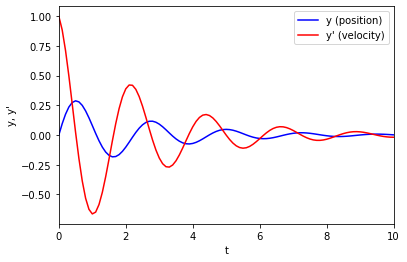

In [14]:
# plot the solution

plt.plot(t, y[:,0], 'b-', label='y (position)')
plt.plot(t, y[:,1], 'r-', label="y' (velocity)")
plt.xlim([0,10])
plt.xlabel('t')
plt.ylabel("y, y'")
plt.legend()

**Exercise**

1. Why does the initial condition $y(0)=0, y'(0)=1$ corresponds to `yinit=(0,1)`? Does it match the curves in the plot at $t=0$?
2. Use a different initial condition $y(0)=2$ and $y'(0)=2$ and repeat the calculation. Plot the solution.

## Example 3: disease transmission

Consider the SEIR model discussed previously:

$$
\frac{dS}{dt} = -\frac{\beta S I}{N} \\
\frac{dE}{dt} = \frac{\beta SI}{N} - \sigma E \\
\frac{dI}{dt} = \sigma E - \gamma I \\
\frac{dR}{dt} = \gamma I \\
N = S + E + I + R
$$

where
$\beta$ is the infection rate, $\sigma$ the incubation rate, and $\gamma$ the recover rate.

Ref: https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model

In [15]:
from scipy import integrate

def rhs_seir(z, t, beta, sigma, gamma):
    """
    Reference https://www.idmod.org/docs/hiv/model-seir.html
    """
    S, E, I, R = z
    N = S + E + I + R
    dSdt = -beta*S*I/N
    dEdt = beta*S*I/N - sigma*E
    dIdt = sigma*E - gamma*I
    dRdt = gamma*I
    return [dSdt, dEdt, dIdt, dRdt]

In [16]:
def ode_solver(t, initial_conditions, params):
    initE, initI, initR, initN = initial_conditions
    beta, sigma, gamma = params
    initS = initN - (initE + initI + initR)
    res = integrate.odeint(rhs_seir, [initS, initE, initI, initR], t, args=(beta, sigma, gamma))
    return res

We assume the following parameters:

In [17]:
t = np.linspace(0, 150, 300)
initE = 0
initI = 1
initR = 0
initN = 300000000     # total population
ic = [initE, initI, initR, initN]
beta = 1.38      # infection rate
sigma = 0.19     # incubation rate
gamma = 0.34     # recovery rate
params = [beta, sigma, gamma]
res = ode_solver(t, ic, params)

In [18]:
res.shape

(300, 4)

In [19]:
S, E, I, R = res[:,0], res[:,1], res[:,2], res[:,3]

(0.0, 150.0)

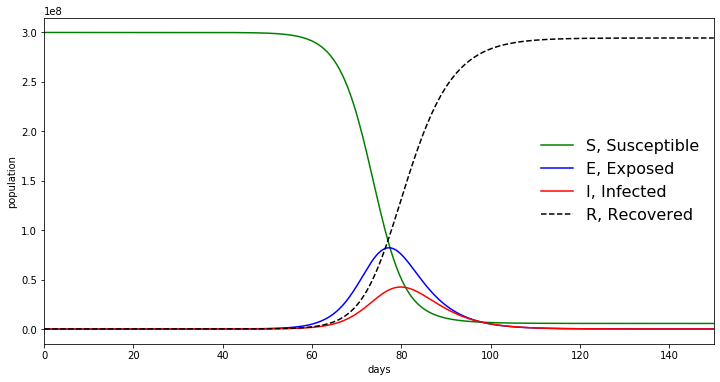

In [20]:
plt.figure(figsize=(12,6))
plt.plot(t, S, 'g-', label='S, Susceptible')
plt.plot(t, E, 'b-', label='E, Exposed')
plt.plot(t, I, 'r-', label='I, Infected')
plt.plot(t, R, 'k--', label='R, Recovered')
plt.ylabel('population')
plt.xlabel('days')
plt.legend(fontsize=16, frameon=False)
plt.xlim([t[0], t[-1]])

**Exercise**

1. What is the infected population if `initE = initI = initR = 0`?
2. Try different values of `beta`, `sigma` and `gamma`, and see how the peaks of `S`, `E`, `I`, `R` move? Does the trend follow your intuition?